In [38]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, REST
import matplotlib.pyplot as plt
import numpy as np
import time
import talib


SEC_KEY = 'BiQZ7lKjbL2AFjCEEE2laRXA98phAR3AdPXhTVvn'
PUB_KEY = 'PKL4C9JZ51CO2MF6HUAH'
BASE_URL = 'https://paper-api.alpaca.markets'
CRYPTO_URL = 'https://data.alpaca.markets/v1beta1/crypto'
api = tradeapi.REST(key_id= PUB_KEY, secret_key=SEC_KEY, base_url=BASE_URL)

%matplotlib inline

In [78]:
plt.rcParams["figure.figsize"] = (20,8)


In [99]:
df = api.get_bars('BRK.B', TimeFrame.Hour, "2022-01-01", "2022-02-17", limit=50000, adjustment='raw').df


In [100]:
len(df)

483

In [101]:
df.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:00:00+00:00,300.15,300.15,300.150,300.150,575,21,300.176644
2022-01-03 10:00:00+00:00,301.40,301.40,301.400,301.400,300,2,301.400000
2022-01-03 11:00:00+00:00,301.31,301.31,301.310,301.310,115,2,301.315217
2022-01-03 12:00:00+00:00,301.00,301.44,301.000,301.000,1157,26,301.158444
2022-01-03 13:00:00+00:00,300.99,301.00,300.725,300.725,2122,65,300.922799


In [102]:
_10ma = talib.SMA(df['close'], timeperiod=10)
_20ma = talib.SMA(df['close'], timeperiod=20)
_50ma = talib.SMA(df['close'], timeperiod=50)
_200ma = talib.SMA(df['close'], timeperiod=200)

In [103]:
df['_10ma'] = _10ma
df['_20ma'] = _20ma
df['_50ma'] = _50ma
df['_200ma'] = _200ma

In [104]:
df['_20-10ma'] = df['_20ma'] - df['_10ma']
df['_50-20ma'] = df['_50ma'] - df['_20ma']
df['_200-50ma'] = df['_200ma'] - df['_50ma']

In [105]:
df['_10-20ma'] = (df['_10ma'] - df['_20ma'])/df['_20ma']
df['_20-50ma'] = df['_20ma'] - df['_50ma']
df['_50-200ma'] = df['_50ma'] - df['_200ma']

/Users/ijd/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


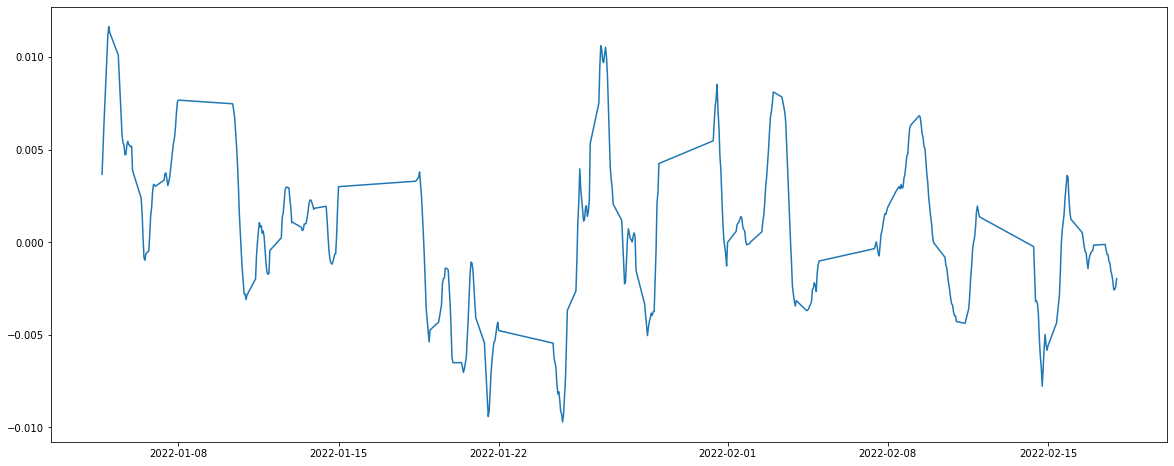

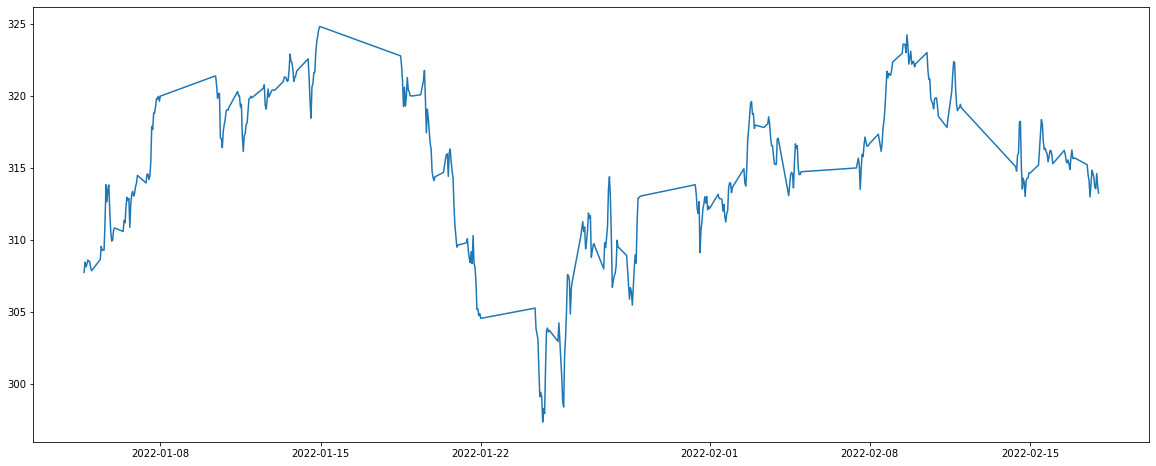

In [106]:
to_plot = df[["_10-20ma","vwap"]]
to_plot.dropna(inplace=True)

plt.plot(to_plot.index, to_plot['_10-20ma'])

plt.show()
plt.plot(to_plot.index, to_plot['vwap'])
plt.show()


/Users/ijd/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


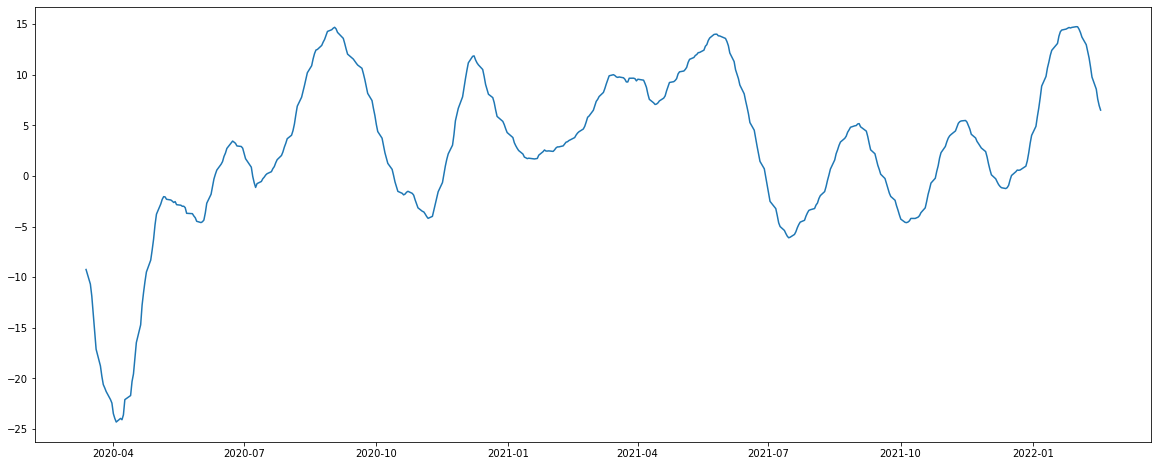

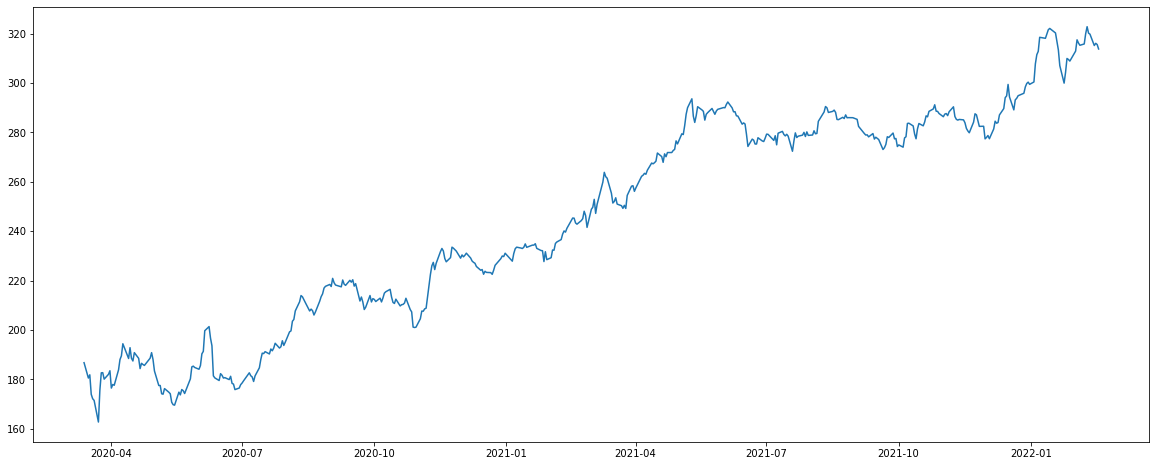

In [80]:
to_plot = df[["_20-50ma","vwap"]]
to_plot.dropna(inplace=True)

plt.plot(to_plot.index, to_plot['_20-50ma'])

plt.show()
plt.plot(to_plot.index, to_plot['vwap'])
plt.show()

In [2]:
#LOCAL BACTEST
symb = "SPY"
pos_held = False
hours_to_test = 2

print("Checking Price")
market_data = api.get_barset(symb, 'minute', limit=(60 * hours_to_test)) # Pull market data from the past 60x minutes

close_list = []
for bar in market_data[symb]:
    close_list.append(bar.c)



print("Open: " + str(close_list[0]))
print("Close: " + str(close_list[60 * hours_to_test - 1]))


close_list = np.array(close_list, dtype=np.float64)
startBal = 2000 # Start out with 2000 dollars
balance = startBal
buys = 0
sells = 0



for i in range(4, 60 * hours_to_test): # Start four minutes in, so that MA can be calculated
    ma = np.mean(close_list[i-4:i+1])
    last_price = close_list[i]

    print("Moving Average: " + str(ma))
    print("Last Price: " + str(last_price))

    if ma + 0.1 < last_price and not pos_held:
        print("Buy")
        balance -= last_price
        pos_held = True
        buys += 1
    elif ma - 0.1 > last_price and pos_held:
        print("Sell")
        balance += last_price
        pos_held = False
        sells += 1
    print(balance)
    time.sleep(0.01)

print("")
print("Buys: " + str(buys))
print("Sells: " + str(sells))

if buys > sells:
    balance += close_list[60 * hours_to_test - 1] # Add back your equity to your balance
    

print("Final Balance: " + str(balance))

print("Profit if held: " + str(close_list[60 * hours_to_test - 1] - close_list[0]))
print("Profit from algorithm: " + str(balance - startBal))

Checking Price


/var/folders/5r/t7bwx3d901lgqf_w8cq0ch7h0000gn/T/ipykernel_28012/2695628981.py:15: DeprecatedWarning: get_barset is deprecated as of v1.0.0. Use get_bars instead
  market_data = api.get_barset(symb, 'minute', limit=(60 * hours_to_test)) # Pull market data from the past 60x minutes


Open: 434.025
Close: 434.9
Moving Average: 434.13499999999993
Last Price: 434.33
Buy
1565.67
Moving Average: 434.296
Last Price: 434.83
1565.67
Moving Average: 434.4219999999999
Last Price: 434.805
1565.67
Moving Average: 434.591
Last Price: 434.87
1565.67
Moving Average: 434.74300000000005
Last Price: 434.88
1565.67
Moving Average: 434.869
Last Price: 434.96
1565.67
Moving Average: 434.92699999999996
Last Price: 435.12
1565.67
Moving Average: 434.98199999999997
Last Price: 435.08
1565.67
Moving Average: 435.076
Last Price: 435.34
1565.67
Moving Average: 435.24799999999993
Last Price: 435.74
1565.67
Moving Average: 435.387
Last Price: 435.655
1565.67
Moving Average: 435.491
Last Price: 435.64
1565.67
Moving Average: 435.61499999999995
Last Price: 435.7
1565.67
Moving Average: 435.80100000000004
Last Price: 436.27
1565.67
Moving Average: 435.929
Last Price: 436.38
1565.67
Moving Average: 436.05999999999995
Last Price: 436.31
1565.67
Moving Average: 436.254
Last Price: 436.61
1565.67
Mov